In [1]:
# Установка transformers
!pip install transformers

In [2]:
import pandas as pd
from itertools import groupby

In [3]:
#import необходимых модулей

import pandas as pd
#from ludwig.api import LudwigModel
#from ludwig.visualize import learning_curves
import yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
from datetime import datetime, timedelta

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import pickle

In [4]:
from matplotlib.pylab import float64
#Считывание данных в DataFrame 

train= pd.read_csv('/kaggle/input/russianpost/train_1half.csv', sep=',', index_col=None)
test= pd.read_csv('/kaggle/input/russianpost/test_dataset_test.csv', sep=',', index_col=None)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
train['oper_type + oper_attr']=train['oper_type + oper_attr'].astype(str)
test['oper_type + oper_attr']=test['oper_type + oper_attr'].astype(str)


train['index_oper']=train['index_oper'].astype(str)
test['index_oper']=test['index_oper'].astype(str)

train['priority']=train['priority'].astype(str)
test['priority']=test['priority'].astype(str)

train['class']=train['class'].astype(str)
test['class']=test['class'].astype(str)

train['mailtype']=train['mailtype'].astype(str)
test['mailtype']=test['mailtype'].astype(str)

train['mailctg']=train['mailctg'].astype(str)
test['mailctg']=test['mailctg'].astype(str)

train['mailrank']=train['mailrank'].astype(str)
test['mailrank']=test['mailrank'].astype(str)

train['directctg']=train['directctg'].astype(str)
test['directctg']=test['directctg'].astype(str)

train['postmark']=train['postmark'].astype(str)
test['postmark']=test['postmark'].astype(str)

In [6]:
train

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629,Участок,7503,N,0,Y,N,87,...,42,720176,58950,779126,8290896,0,0,0,0,0
1,9907176,1023_-1,102976,ММПО,7503,N,0,N,N,107,...,914,48856658,83318932,132175590,136819803,0,0,0,0,0
2,3304275,1018_-1,620962,Цех,7503,N,0,Y,N,50,...,62,3246292,3233068,6479360,52708071,0,1,0,0,0
3,9020937,1019_-1,344964,Цех,7503,N,0,Y,N,416,...,55,2060928,653280,2714208,19562334,0,0,0,0,0
4,3082311,1020_-1,629819,Участок,7503,N,0,Y,N,795,...,16,316919,27911,344830,4719186,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3070974,1355531,1004_-1,102976,ММПО,7503,N,0,N,N,613,...,914,48856658,83318932,132175590,136819803,0,0,0,0,1
3070975,4197571,2_1,676850,ГОПС,7506,N,2,Y,N,859,...,13,18372,7199,25571,83685,0,0,0,0,1
3070976,2676188,1004_-1,102976,ММПО,7503,N,0,N,N,33,...,972,68766046,91123247,159889293,164927295,0,0,0,0,1
3070977,6324167,2_1,603128,ГОПС,7504,N,3,Y,N,327,...,12,3917,2420,6337,73399,0,0,0,0,1


In [7]:
test

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address
0,7815282,8_13,102976.0,ММПО,7503.0,N,0.0,N,N,85.0,...,489.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,0,0,0,0
1,8443555,8_2,238753.0,ГОПС,7503.0,N,4.0,Y,N,21.0,...,186.0,2.0,2895.0,1545.0,4440.0,20623.0,0,1,1,0
2,6352559,1020_-1,618254.0,ГОПС,7503.0,N,4.0,Y,N,388.0,...,500.0,3.0,2751.0,993.0,3744.0,37817.0,0,0,0,0
3,4921420,1016_-1,102968.0,ТИ,7503.0,N,0.0,N,N,1203.0,...,0.0,69.0,9379609.0,2267333.0,11646942.0,11759329.0,0,1,0,0
4,1420440,1018_-1,102971.0,Цех,7506.0,N,0.0,N,N,956.0,...,1267.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,9030800,1017_1001,655003.0,ГОПС,7503.0,N,4.0,Y,N,53.0,...,262.0,3.0,4297.0,1803.0,6100.0,64613.0,0,0,0,0
3999996,6275048,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,286.0,...,0.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,1,0,0
3999997,4701757,1022_-1,102969.0,ТИ,7503.0,N,0.0,N,N,733.0,...,300.0,106.0,17348074.0,3469387.0,20817461.0,20821109.0,0,1,0,0
3999998,611153,39_-1,104006.0,Участок,7503.0,N,0.0,N,N,265.0,...,500.0,2.0,15.0,13673720.0,13673735.0,14041298.0,0,0,0,0


In [8]:
train.columns

Index(['id', 'oper_type + oper_attr', 'index_oper', 'type', 'priority',
       'is_privatecategory', 'class', 'is_in_yandex', 'is_return', 'weight',
       'mailtype', 'mailctg', 'mailrank', 'directctg', 'transport_pay',
       'postmark', 'name_mfi', 'weight_mfi', 'price_mfi',
       'dist_qty_oper_login_1', 'total_qty_oper_login_1',
       'total_qty_oper_login_0', 'total_qty_over_index_and_type',
       'total_qty_over_index', 'is_wrong_sndr_name', 'is_wrong_rcpn_name',
       'is_wrong_phone_number', 'is_wrong_address', 'label'],
      dtype='object')

In [9]:
columns_to_train=['index_oper', 'type', 'priority',
       'is_privatecategory', 'class', 'is_in_yandex', 'is_return', 'weight',
       'mailtype', 'mailctg', 'mailrank', 'directctg', 'transport_pay',
       'postmark',  'weight_mfi', 'price_mfi',
       'dist_qty_oper_login_1', 'total_qty_oper_login_1',
       'total_qty_oper_login_0', 'total_qty_over_index_and_type',
       'total_qty_over_index', 'is_wrong_sndr_name', 'is_wrong_rcpn_name',
       'is_wrong_phone_number', 'is_wrong_address'
                 # ,'oper_type + oper_attr'
]

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 28 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       object 
 5   is_privatecategory             object 
 6   class                          object 
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       object 
 11  mailctg                        object 
 12  mailrank                       object 
 13  directctg                      object 
 14  transport_pay                  float64
 15  postmark                       object 
 16  name_mfi                       object 
 17  weight_mfi                     float64
 18  pr

In [11]:
column_names_to_linear =['weight',  'transport_pay', 
       'weight_mfi', 'price_mfi', 'dist_qty_oper_login_1',
       'total_qty_oper_login_1', 'total_qty_oper_login_0',
       'total_qty_over_index_and_type', 'total_qty_over_index']

train_num=train[['id']]
test_num=test[['id']]
test['label']=0

train_all=pd.concat([train,test])

train_all=train_all.fillna(0)

#train_all['oper_type + oper_attr']=train_all['oper_type + oper_attr'].astype(str)
train_all['index_oper']=train_all['index_oper'].astype(str)
train_all['priority']=train_all['priority'].astype(str)
train_all['class']=train_all['class'].astype(str)
train_all['mailtype']=train_all['mailtype'].astype(str)
train_all['mailctg']=train_all['mailctg'].astype(str)
train_all['mailrank']=train_all['mailrank'].astype(str)
train_all['directctg']=train_all['directctg'].astype(str)
train_all['postmark']=train_all['postmark'].astype(str)


#train_all['oper_type + oper_attr']=train_all['oper_type + oper_attr'].astype("category").cat.codes
train_all['index_oper']=train_all['index_oper'].astype("category").cat.codes
train_all['type']=train_all['type'].astype("category").cat.codes
train_all['priority']=train_all['priority'].astype("category").cat.codes
train_all['is_privatecategory']=train_all['is_privatecategory'].astype("category").cat.codes
train_all['class']=train_all['class'].astype("category").cat.codes
train_all['is_in_yandex']=train_all['is_in_yandex'].astype("category").cat.codes
train_all['is_return']=train_all['is_return'].astype("category").cat.codes
train_all['mailtype']=train_all['mailtype'].astype("category").cat.codes
train_all['mailctg']=train_all['mailctg'].astype("category").cat.codes
train_all['mailrank']=train_all['mailrank'].astype("category").cat.codes
train_all['directctg']=train_all['directctg'].astype("category").cat.codes
train_all['postmark']=train_all['postmark'].astype("category").cat.codes
train_all['is_wrong_sndr_name']=train_all['is_wrong_sndr_name'].astype("category").cat.codes
train_all['is_wrong_rcpn_name']=train_all['is_wrong_rcpn_name'].astype("category").cat.codes
train_all['is_wrong_phone_number']=train_all['is_wrong_phone_number'].astype("category").cat.codes
train_all['is_wrong_address']=train_all['is_wrong_address'].astype("category").cat.codes

train_all[column_names_to_linear]=np.log(1+train_all[column_names_to_linear])

test_all=test_num.merge(train_all,how='left',on='id')
train_all=train_num.merge(train_all,how='left',on='id')



In [12]:
train_all = train_all.sample(frac=1).reset_index(drop=True)
train_all

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,209959,1018_-1,33,19,6,1,0,1,0,6.311735,...,5.220356,18.028249,8.970940,18.028365,18.105712,0,0,0,0,0
1,3714211,8_2,4425,3,2,1,8,2,0,3.663562,...,1.098612,6.261492,5.337538,6.594413,10.088971,0,0,1,0,0
2,1460946,1004_-1,39,4,2,1,0,1,0,2.833213,...,7.041412,17.918588,18.380682,18.869239,18.914421,0,1,1,0,1
3,2340224,1019_-1,9,19,6,1,0,1,0,5.176150,...,4.382027,15.802579,10.709651,15.808700,17.063914,0,0,0,0,0
4,8831056,1022_-1,45,15,2,1,0,1,0,2.564949,...,3.737670,15.783285,15.011735,16.163292,16.170550,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3070974,1973136,1042_-1,29005,18,2,1,0,2,0,5.899897,...,3.258097,13.420893,11.897834,13.618138,15.553928,0,0,0,0,0
3070975,2891139,39_-1,50,18,2,1,0,1,0,4.727388,...,1.098612,2.772589,16.430986,16.430987,16.457513,0,0,0,0,0
3070976,7410031,8_2,25774,3,6,1,4,2,0,4.290459,...,3.091042,9.144521,8.261010,9.490393,13.429813,0,0,1,0,0
3070977,6677248,1018_-1,8114,10,2,1,4,2,0,4.174387,...,1.945910,11.606753,9.399555,11.711112,14.173818,0,1,0,0,0


In [13]:
# Обучение разделению 
xgb_estimator = xgb.XGBClassifier(
    learning_rate =0.15,
     n_estimators=50,
     max_depth=24,
     min_child_weight=6,
     gamma=2.5,
     verbosity=2,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     tree_method='gpu_hist',gpu_id=0,
           predictor='gpu_predictor',
    enable_categorical=True, 
    use_label_encoder=False,
     max_cat_to_onehot =500,
     eval_metric='auc',
     seed=68,
     feature_fraction=0.7,
     scale_pos_weight=5)

In [14]:
%%time
# fit first model

xgb_estimator.fit(train_all[columns_to_train], train_all['label'])

[23:31:34] WARNING: ../src/learner.cc:627: 
Parameters: { "feature_fraction" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: user 37.1 s, sys: 1.16 s, total: 38.2 s
Wall time: 38.8 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='auc', feature_fraction=0.7, gamma=2.5, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.15, max_bin=256,
              max_cat_to_onehot=500, max_delta_step=0, max_depth=24,
              max_leaves=0, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=68, ...)

In [15]:
#pickle.dump(xgb_estimator, open("xgb.pkl", "wb"))

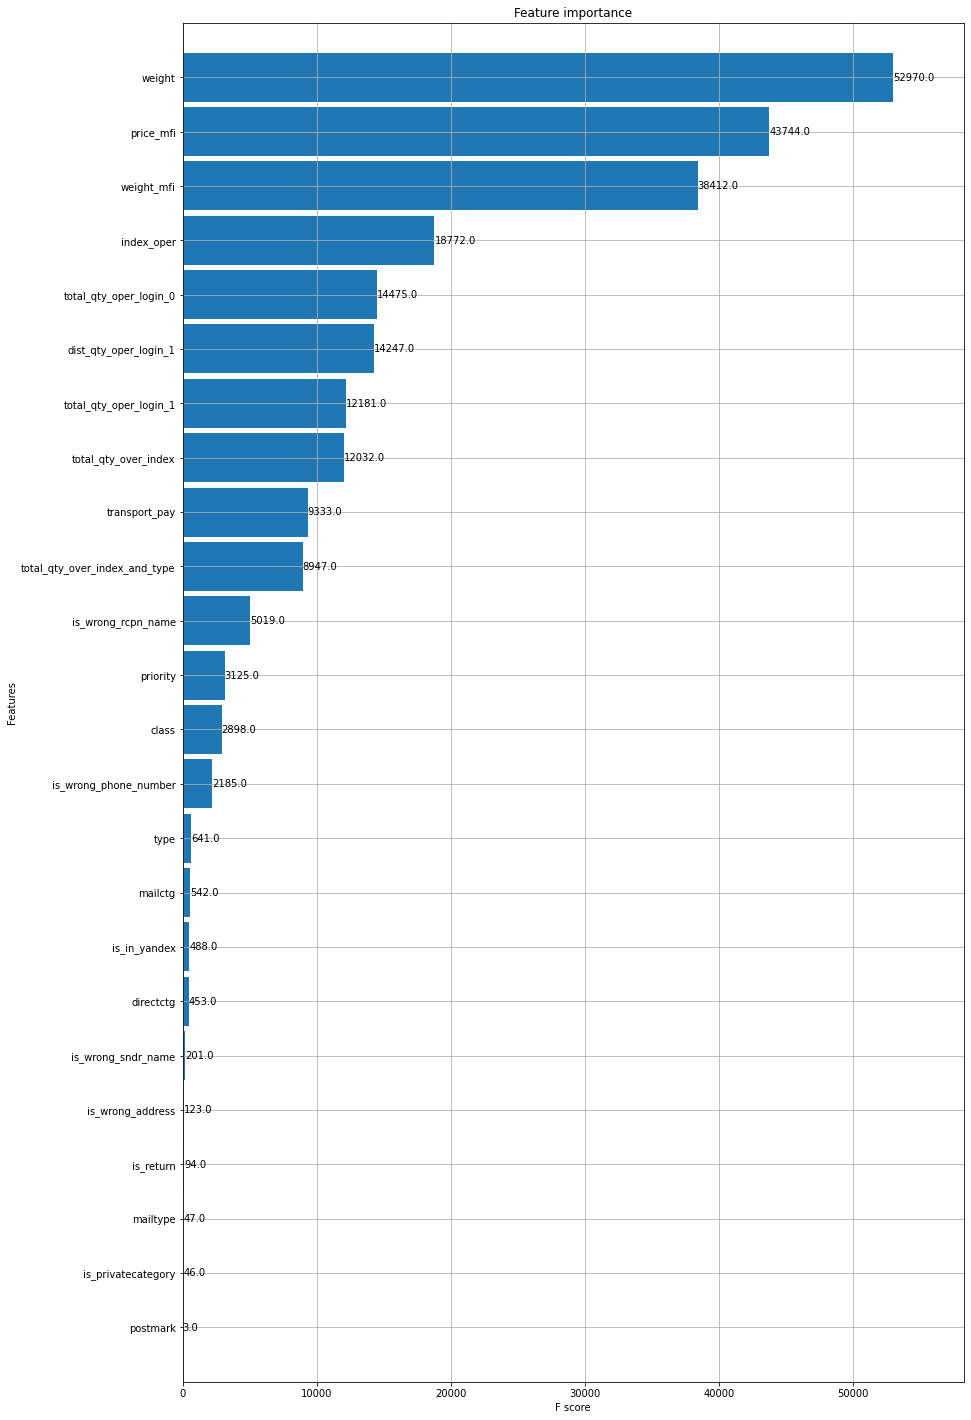

In [16]:
# Важность признаков XGBoost
# 
plt.rcParams["figure.figsize"] = (14, 25)
_ = plot_importance(xgb_estimator, height=0.9)

In [17]:
# Проверка на трейне
predictions = xgb_estimator.predict(train_all[columns_to_train])

print("Значение метрики recall на трейне : ", recall_score(predictions, train_all['label'], average='macro', zero_division=0))

Значение метрики recall на трейне :  0.7578313582717096


In [18]:
# проверка на тесте
predictions_fin= xgb_estimator.predict(test_all[columns_to_train])
test['label']=predictions_fin
test['label'].value_counts()


0    3719191
1     280809
Name: label, dtype: int64

In [19]:
test_itog=test[['id','label']]
test_itog['label']=test_itog['label'].astype(int)
test_itog

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,label
0,7815282,0
1,8443555,1
2,6352559,0
3,4921420,0
4,1420440,0
...,...,...
3999995,9030800,0
3999996,6275048,0
3999997,4701757,0
3999998,611153,0


In [20]:
test_itog.to_csv('Почта xgboost под замену 5 1000 без аттр gpuhist.csv', sep=',', index=False,line_terminator='\n')